<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [BHPD2] - Regression with a Dense Network (DNN) - Advanced code
  <!-- DESC -->  A more advanced implementation of the precedent example
  <!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Predicts **housing prices** from a set of house features. 
 - Understanding the principle and the architecture of a regression with a dense neural network with backup and restore of the trained model. 

The **[Boston Housing Prices Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)** consists of price of houses in various places in Boston.  
Alongside with price, the dataset also provide these information :

 - CRIM: This is the per capita crime rate by town
 - ZN: This is the proportion of residential land zoned for lots larger than 25,000 sq.ft
 - INDUS: This is the proportion of non-retail business acres per town
 - CHAS: This is the Charles River dummy variable (this is equal to 1 if tract bounds river; 0 otherwise)
 - NOX: This is the nitric oxides concentration (parts per 10 million)
 - RM: This is the average number of rooms per dwelling
 - AGE: This is the proportion of owner-occupied units built prior to 1940
 - DIS: This is the weighted distances to five Boston employment centers
 - RAD: This is the index of accessibility to radial highways
 - TAX: This is the full-value property-tax rate per 10,000 dollars
 - PTRATIO: This is the pupil-teacher ratio by town
 - B: This is calculated as 1000(Bk — 0.63)^2, where Bk is the proportion of people of African American descent by town
 - LSTAT: This is the percentage lower status of the population
 - MEDV: This is the median value of owner-occupied homes in 1000 dollars

## What we're going to do :

 - (Retrieve data)
 - (Preparing the data)
 - (Build a model)
 - Train and save the model
 - Restore saved model
 - Evaluate the model
 - Make some predictions


## Step 1 - Import and init

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,sys

from IPython.display import Markdown
from importlib import reload

sys.path.append('..')
import fidle.pwk as pwk

datasets_dir = pwk.init('BHPD2')

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.7
Notebook id          : BHPD2
Run time             : Tuesday 26 January 2021, 19:54:51
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run
Update keras cache   : False
Save figs            : True
Path figs            : ./run/figs


## Step 2 - Retrieve data

### 2.1 - Option 1  : From Keras
Boston housing is a famous historic dataset, so we can get it directly from [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)  

In [2]:
# (x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(test_split=0.2, seed=113)

### 2.2 - Option 2 : From a csv file
More fun !

In [3]:
data = pd.read_csv(f'{datasets_dir}/BHPD/origine/BostonHousing.csv', header=0)

display(data.head(5).style.format("{0:.2f}"))
print('Missing Data : ',data.isna().sum().sum(), '  Shape is : ', data.shape)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


Missing Data :  0   Shape is :  (506, 14)


## Step 3 - Preparing the data
### 3.1 - Split data
We will use 80% of the data for training and 20% for validation.  
x will be input data and y the expected output

In [4]:
# ---- Split => train, test
#
data_train = data.sample(frac=0.7, axis=0)
data_test  = data.drop(data_train.index)

# ---- Split => x,y (medv is price)
#
x_train = data_train.drop('medv',  axis=1)
y_train = data_train['medv']
x_test  = data_test.drop('medv',   axis=1)
y_test  = data_test['medv']

print('Original data shape was : ',data.shape)
print('x_train : ',x_train.shape, 'y_train : ',y_train.shape)
print('x_test  : ',x_test.shape,  'y_test  : ',y_test.shape)

Original data shape was :  (506, 14)
x_train :  (354, 13) y_train :  (354,)
x_test  :  (152, 13) y_test  :  (152,)


### 3.2 - Data normalization
**Note :** 
 - All input data must be normalized, train and test.  
 - To do this we will subtract the mean and divide by the standard deviation.  
 - But test data should not be used in any way, even for normalization.  
 - The mean and the standard deviation will therefore only be calculated with the train data.

In [5]:
display(x_train.describe().style.format("{0:.2f}").set_caption("Before normalization :"))

mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

display(x_train.describe().style.format("{0:.2f}").set_caption("After normalization :"))

x_train, y_train = np.array(x_train), np.array(y_train)
x_test,  y_test  = np.array(x_test),  np.array(y_test)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,3.87,10.97,10.94,0.07,0.55,6.33,68.45,3.75,9.55,405.29,18.34,357.47,12.55
std,9.31,22.80,6.73,0.26,0.12,0.71,28.41,2.02,8.76,169.75,2.21,89.67,7.35
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,2.52,1.73
25%,0.08,0.00,5.13,0.00,0.45,5.92,45.02,2.08,4.00,277.00,16.92,375.24,6.72
50%,0.26,0.00,8.56,0.00,0.53,6.25,78.20,3.30,5.00,322.00,18.70,392.05,10.66
75%,3.85,12.50,18.10,0.00,0.62,6.69,94.10,5.11,24.00,666.00,20.20,396.90,17.11
max,88.98,100.00,27.74,1.00,0.87,8.72,100.00,12.13,24.00,711.00,22.00,396.90,36.98


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat
count,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00,354.00
mean,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.41,-0.48,-1.56,-0.28,-1.47,-3.90,-2.31,-1.30,-0.98,-1.29,-2.60,-3.96,-1.47
25%,-0.41,-0.48,-0.86,-0.28,-0.91,-0.59,-0.82,-0.83,-0.63,-0.76,-0.64,0.20,-0.79
50%,-0.39,-0.48,-0.35,-0.28,-0.19,-0.13,0.34,-0.22,-0.52,-0.49,0.16,0.39,-0.26
75%,-0.00,0.07,1.07,-0.28,0.61,0.50,0.90,0.67,1.65,1.54,0.84,0.44,0.62
max,9.14,3.90,2.50,3.62,2.76,3.36,1.11,4.14,1.65,1.80,1.66,0.44,3.32


## Step 4 - Build a model
More informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

In [6]:
  def get_model_v1(shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape, name="InputLayer"))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n1'))
    model.add(keras.layers.Dense(64, activation='relu', name='Dense_n2'))
    model.add(keras.layers.Dense(1, name='Output'))
    
    model.compile(optimizer = 'rmsprop',
                  loss      = 'mse',
                  metrics   = ['mae', 'mse'] )
    return model

## 5 - Train the model
### 5.1 - Get it

In [7]:
model=get_model_v1( (13,) )

model.summary()
# img=keras.utils.plot_model( model, to_file='./run/model.png', show_shapes=True, show_layer_names=True, dpi=96)
# display(img)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### 5.2 - Add callback

In [8]:
os.makedirs('./run/models',   mode=0o750, exist_ok=True)
save_dir = "./run/models/best_model.h5"

savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, save_best_only=True)

### 5.3 - Train it

In [9]:
history = model.fit(x_train,
                    y_train,
                    epochs          = 100,
                    batch_size      = 10,
                    verbose         = 1,
                    validation_data = (x_test, y_test),
                    callbacks       = [savemodel_callback])

Epoch 1/100


 1/36 [..............................] - ETA: 0s - loss: 524.3780 - mae: 21.8794 - mse: 524.3780

36/36 [==============================] - 0s 5ms/step - loss: 467.0979 - mae: 19.3228 - mse: 467.0979 - val_loss: 233.6538 - val_mae: 13.8746 - val_mse: 233.6538


Epoch 2/100
 1/36 [..............................] - ETA: 0s - loss: 300.4113 - mae: 16.4995 - mse: 300.4113

36/36 [==============================] - 0s 2ms/step - loss: 195.0283 - mae: 11.6077 - mse: 195.0283 - val_loss: 70.7818 - val_mae: 6.9216 - val_mse: 70.7818


Epoch 3/100
 1/36 [..............................] - ETA: 0s - loss: 47.1706 - mae: 5.7595 - mse: 47.1706

36/36 [==============================] - 0s 3ms/step - loss: 71.8525 - mae: 6.4334 - mse: 71.8524 - val_loss: 38.6592 - val_mae: 4.8970 - val_mse: 38.6592


Epoch 4/100
 1/36 [..............................] - ETA: 0s - loss: 49.9734 - mae: 6.3892 - mse: 49.9734

36/36 [==============================] - 0s 2ms/step - loss: 40.7974 - mae: 4.7092 - mse: 40.7974 - val_loss: 24.0020 - val_mae: 3.7493 - val_mse: 24.0020


Epoch 5/100
 1/36 [..............................] - ETA: 0s - loss: 22.6004 - mae: 3.4561 - mse: 22.6004

36/36 [==============================] - 0s 2ms/step - loss: 28.5347 - mae: 3.8565 - mse: 28.5347 - val_loss: 16.7191 - val_mae: 3.0819 - val_mse: 16.7191


Epoch 6/100
 1/36 [..............................] - ETA: 0s - loss: 13.3642 - mae: 3.0078 - mse: 13.3642

36/36 [==============================] - 0s 2ms/step - loss: 23.4328 - mae: 3.3963 - mse: 23.4328 - val_loss: 14.4259 - val_mae: 2.6260 - val_mse: 14.4259


Epoch 7/100
 1/36 [..............................] - ETA: 0s - loss: 11.6618 - mae: 2.4882 - mse: 11.6618

36/36 [==============================] - 0s 2ms/step - loss: 20.8500 - mae: 3.1541 - mse: 20.8500 - val_loss: 13.3741 - val_mae: 2.4950 - val_mse: 13.3741


Epoch 8/100
 1/36 [..............................] - ETA: 0s - loss: 10.1724 - mae: 2.5022 - mse: 10.1724

36/36 [==============================] - 0s 2ms/step - loss: 18.3349 - mae: 2.9900 - mse: 18.3349 - val_loss: 15.4015 - val_mae: 2.6979 - val_mse: 15.4015


Epoch 9/100
 1/36 [..............................] - ETA: 0s - loss: 21.0187 - mae: 3.2410 - mse: 21.0187

36/36 [==============================] - 0s 2ms/step - loss: 17.0373 - mae: 2.9033 - mse: 17.0373 - val_loss: 13.4447 - val_mae: 2.4656 - val_mse: 13.4447


Epoch 10/100
 1/36 [..............................] - ETA: 0s - loss: 30.8257 - mae: 4.0180 - mse: 30.8257

36/36 [==============================] - 0s 2ms/step - loss: 16.0808 - mae: 2.7871 - mse: 16.0808 - val_loss: 12.8156 - val_mae: 2.4046 - val_mse: 12.8156


Epoch 11/100
 1/36 [..............................] - ETA: 0s - loss: 71.0791 - mae: 4.3979 - mse: 71.0791

36/36 [==============================] - 0s 2ms/step - loss: 14.9430 - mae: 2.6840 - mse: 14.9430 - val_loss: 14.8045 - val_mae: 2.7067 - val_mse: 14.8045


Epoch 12/100
 1/36 [..............................] - ETA: 0s - loss: 14.6289 - mae: 2.2989 - mse: 14.6289

36/36 [==============================] - 0s 2ms/step - loss: 14.5115 - mae: 2.6697 - mse: 14.5115 - val_loss: 14.0469 - val_mae: 2.5745 - val_mse: 14.0469


Epoch 13/100
 1/36 [..............................] - ETA: 0s - loss: 8.7410 - mae: 2.5464 - mse: 8.7410

36/36 [==============================] - 0s 2ms/step - loss: 13.4514 - mae: 2.5984 - mse: 13.4514 - val_loss: 14.1000 - val_mae: 2.4858 - val_mse: 14.1000


Epoch 14/100
 1/36 [..............................] - ETA: 0s - loss: 0.4068 - mae: 0.5584 - mse: 0.4068

36/36 [==============================] - 0s 2ms/step - loss: 13.2222 - mae: 2.5593 - mse: 13.2222 - val_loss: 14.2723 - val_mae: 2.5066 - val_mse: 14.2723


Epoch 15/100
 1/36 [..............................] - ETA: 0s - loss: 1.5703 - mae: 0.9647 - mse: 1.5703

36/36 [==============================] - 0s 2ms/step - loss: 12.6321 - mae: 2.5047 - mse: 12.6321 - val_loss: 15.0925 - val_mae: 2.5999 - val_mse: 15.0925


Epoch 16/100
 1/36 [..............................] - ETA: 0s - loss: 10.1997 - mae: 2.4069 - mse: 10.1997

36/36 [==============================] - 0s 2ms/step - loss: 12.4821 - mae: 2.4709 - mse: 12.4821 - val_loss: 14.6766 - val_mae: 2.5090 - val_mse: 14.6766


Epoch 17/100
 1/36 [..............................] - ETA: 0s - loss: 12.9664 - mae: 2.9900 - mse: 12.9664

36/36 [==============================] - 0s 2ms/step - loss: 11.8343 - mae: 2.4466 - mse: 11.8343 - val_loss: 17.5553 - val_mae: 2.7488 - val_mse: 17.5553


Epoch 18/100
 1/36 [..............................] - ETA: 0s - loss: 3.9327 - mae: 1.4241 - mse: 3.9327

36/36 [==============================] - 0s 2ms/step - loss: 11.8791 - mae: 2.4358 - mse: 11.8791 - val_loss: 15.9580 - val_mae: 2.6200 - val_mse: 15.9580


Epoch 19/100
 1/36 [..............................] - ETA: 0s - loss: 13.9959 - mae: 2.1576 - mse: 13.9959

36/36 [==============================] - 0s 2ms/step - loss: 11.5409 - mae: 2.3841 - mse: 11.5409 - val_loss: 13.7806 - val_mae: 2.4106 - val_mse: 13.7806


Epoch 20/100
 1/36 [..............................] - ETA: 0s - loss: 2.1087 - mae: 1.1726 - mse: 2.1087

36/36 [==============================] - 0s 2ms/step - loss: 11.2718 - mae: 2.3894 - mse: 11.2718 - val_loss: 13.4664 - val_mae: 2.4109 - val_mse: 13.4664


Epoch 21/100
 1/36 [..............................] - ETA: 0s - loss: 6.3415 - mae: 1.9045 - mse: 6.3415

36/36 [==============================] - 0s 2ms/step - loss: 10.9951 - mae: 2.3595 - mse: 10.9951 - val_loss: 13.3964 - val_mae: 2.4144 - val_mse: 13.3964


Epoch 22/100
 1/36 [..............................] - ETA: 0s - loss: 9.5904 - mae: 2.4972 - mse: 9.5904

36/36 [==============================] - 0s 2ms/step - loss: 11.0492 - mae: 2.3240 - mse: 11.0492 - val_loss: 14.8691 - val_mae: 2.5965 - val_mse: 14.8691


Epoch 23/100
 1/36 [..............................] - ETA: 0s - loss: 4.6876 - mae: 1.8583 - mse: 4.6876

36/36 [==============================] - 0s 2ms/step - loss: 10.9001 - mae: 2.3505 - mse: 10.9001 - val_loss: 14.0787 - val_mae: 2.4629 - val_mse: 14.0787


Epoch 24/100
 1/36 [..............................] - ETA: 0s - loss: 4.5074 - mae: 1.7547 - mse: 4.5074

36/36 [==============================] - 0s 2ms/step - loss: 10.4978 - mae: 2.3235 - mse: 10.4978 - val_loss: 15.2084 - val_mae: 2.5026 - val_mse: 15.2084


Epoch 25/100
 1/36 [..............................] - ETA: 0s - loss: 13.8617 - mae: 2.6182 - mse: 13.8617

36/36 [==============================] - 0s 2ms/step - loss: 10.2588 - mae: 2.2522 - mse: 10.2588 - val_loss: 13.9885 - val_mae: 2.4260 - val_mse: 13.9885


Epoch 26/100
 1/36 [..............................] - ETA: 0s - loss: 3.5520 - mae: 1.4436 - mse: 3.5520

36/36 [==============================] - 0s 2ms/step - loss: 10.3342 - mae: 2.2388 - mse: 10.3342 - val_loss: 14.8985 - val_mae: 2.4891 - val_mse: 14.8985


Epoch 27/100
 1/36 [..............................] - ETA: 0s - loss: 3.1920 - mae: 1.4843 - mse: 3.1920

36/36 [==============================] - 0s 2ms/step - loss: 10.2799 - mae: 2.2577 - mse: 10.2799 - val_loss: 14.5281 - val_mae: 2.4353 - val_mse: 14.5281


Epoch 28/100
 1/36 [..............................] - ETA: 0s - loss: 7.7371 - mae: 2.6583 - mse: 7.7371

36/36 [==============================] - 0s 2ms/step - loss: 10.1663 - mae: 2.2689 - mse: 10.1663 - val_loss: 15.2487 - val_mae: 2.4824 - val_mse: 15.2487


Epoch 29/100
 1/36 [..............................] - ETA: 0s - loss: 2.9523 - mae: 1.4449 - mse: 2.9523

36/36 [==============================] - 0s 2ms/step - loss: 9.7568 - mae: 2.2178 - mse: 9.7568 - val_loss: 13.6135 - val_mae: 2.4157 - val_mse: 13.6135


Epoch 30/100
 1/36 [..............................] - ETA: 0s - loss: 3.4264 - mae: 1.4332 - mse: 3.4264

36/36 [==============================] - 0s 2ms/step - loss: 9.7425 - mae: 2.1890 - mse: 9.7425 - val_loss: 14.3603 - val_mae: 2.3989 - val_mse: 14.3603


Epoch 31/100
 1/36 [..............................] - ETA: 0s - loss: 14.0334 - mae: 2.7793 - mse: 14.0334

36/36 [==============================] - 0s 2ms/step - loss: 9.5316 - mae: 2.1989 - mse: 9.5316 - val_loss: 15.8344 - val_mae: 2.4792 - val_mse: 15.8344


Epoch 32/100
 1/36 [..............................] - ETA: 0s - loss: 4.4990 - mae: 1.6793 - mse: 4.4990

36/36 [==============================] - 0s 2ms/step - loss: 9.4923 - mae: 2.1851 - mse: 9.4923 - val_loss: 15.3201 - val_mae: 2.4703 - val_mse: 15.3201


Epoch 33/100
 1/36 [..............................] - ETA: 0s - loss: 5.1678 - mae: 2.0134 - mse: 5.1678

36/36 [==============================] - 0s 2ms/step - loss: 9.2678 - mae: 2.1497 - mse: 9.2678 - val_loss: 14.2147 - val_mae: 2.4070 - val_mse: 14.2147


Epoch 34/100
 1/36 [..............................] - ETA: 0s - loss: 11.6074 - mae: 3.1264 - mse: 11.6074

36/36 [==============================] - 0s 2ms/step - loss: 9.2110 - mae: 2.1784 - mse: 9.2110 - val_loss: 15.0654 - val_mae: 2.4302 - val_mse: 15.0654


Epoch 35/100
 1/36 [..............................] - ETA: 0s - loss: 3.7268 - mae: 1.5328 - mse: 3.7268

36/36 [==============================] - 0s 2ms/step - loss: 9.1832 - mae: 2.1923 - mse: 9.1832 - val_loss: 16.7386 - val_mae: 2.5730 - val_mse: 16.7386


Epoch 36/100
 1/36 [..............................] - ETA: 0s - loss: 8.6838 - mae: 2.0733 - mse: 8.6838

36/36 [==============================] - 0s 2ms/step - loss: 9.1930 - mae: 2.1447 - mse: 9.1930 - val_loss: 16.6296 - val_mae: 2.5571 - val_mse: 16.6296


Epoch 37/100
 1/36 [..............................] - ETA: 0s - loss: 9.4591 - mae: 2.3174 - mse: 9.4591

36/36 [==============================] - 0s 2ms/step - loss: 9.0360 - mae: 2.1081 - mse: 9.0360 - val_loss: 15.0219 - val_mae: 2.5468 - val_mse: 15.0219


Epoch 38/100
 1/36 [..............................] - ETA: 0s - loss: 20.9985 - mae: 3.1362 - mse: 20.9985

36/36 [==============================] - 0s 2ms/step - loss: 9.2309 - mae: 2.1284 - mse: 9.2309 - val_loss: 14.6210 - val_mae: 2.4106 - val_mse: 14.6210


Epoch 39/100
 1/36 [..............................] - ETA: 0s - loss: 9.2294 - mae: 2.1900 - mse: 9.2294

36/36 [==============================] - 0s 2ms/step - loss: 8.6420 - mae: 2.0510 - mse: 8.6420 - val_loss: 15.9267 - val_mae: 2.5104 - val_mse: 15.9267


Epoch 40/100
 1/36 [..............................] - ETA: 0s - loss: 8.7841 - mae: 2.2367 - mse: 8.7841

36/36 [==============================] - 0s 2ms/step - loss: 8.9458 - mae: 2.1086 - mse: 8.9458 - val_loss: 15.1429 - val_mae: 2.4586 - val_mse: 15.1429


Epoch 41/100
 1/36 [..............................] - ETA: 0s - loss: 18.0614 - mae: 2.7943 - mse: 18.0614

36/36 [==============================] - 0s 2ms/step - loss: 8.6823 - mae: 2.0774 - mse: 8.6823 - val_loss: 15.4000 - val_mae: 2.5159 - val_mse: 15.4000


Epoch 42/100
 1/36 [..............................] - ETA: 0s - loss: 2.1116 - mae: 1.2488 - mse: 2.1116

36/36 [==============================] - 0s 2ms/step - loss: 8.7357 - mae: 2.1002 - mse: 8.7357 - val_loss: 14.7425 - val_mae: 2.4641 - val_mse: 14.7425


Epoch 43/100
 1/36 [..............................] - ETA: 0s - loss: 4.9758 - mae: 1.8679 - mse: 4.9758

36/36 [==============================] - 0s 2ms/step - loss: 8.6302 - mae: 2.0474 - mse: 8.6302 - val_loss: 14.1730 - val_mae: 2.3890 - val_mse: 14.1730


Epoch 44/100
 1/36 [..............................] - ETA: 0s - loss: 4.7192 - mae: 1.5913 - mse: 4.7192

36/36 [==============================] - 0s 2ms/step - loss: 8.5196 - mae: 2.0489 - mse: 8.5196 - val_loss: 13.7067 - val_mae: 2.3802 - val_mse: 13.7067


Epoch 45/100
 1/36 [..............................] - ETA: 0s - loss: 5.7594 - mae: 1.8951 - mse: 5.7594

36/36 [==============================] - 0s 2ms/step - loss: 8.1720 - mae: 2.0400 - mse: 8.1720 - val_loss: 14.6779 - val_mae: 2.4595 - val_mse: 14.6779


Epoch 46/100
 1/36 [..............................] - ETA: 0s - loss: 2.8601 - mae: 1.5299 - mse: 2.8601

36/36 [==============================] - 0s 2ms/step - loss: 8.3514 - mae: 2.0421 - mse: 8.3514 - val_loss: 15.1503 - val_mae: 2.4545 - val_mse: 15.1503


Epoch 47/100
 1/36 [..............................] - ETA: 0s - loss: 4.5904 - mae: 1.7153 - mse: 4.5904

36/36 [==============================] - 0s 2ms/step - loss: 8.3631 - mae: 2.0426 - mse: 8.3631 - val_loss: 14.6039 - val_mae: 2.4286 - val_mse: 14.6039


Epoch 48/100
 1/36 [..............................] - ETA: 0s - loss: 9.0141 - mae: 2.2861 - mse: 9.0141

36/36 [==============================] - 0s 2ms/step - loss: 8.1321 - mae: 2.0243 - mse: 8.1321 - val_loss: 14.4469 - val_mae: 2.4445 - val_mse: 14.4469


Epoch 49/100
 1/36 [..............................] - ETA: 0s - loss: 3.7271 - mae: 1.5320 - mse: 3.7271

36/36 [==============================] - 0s 2ms/step - loss: 8.0881 - mae: 1.9876 - mse: 8.0881 - val_loss: 15.2589 - val_mae: 2.4690 - val_mse: 15.2589


Epoch 50/100
 1/36 [..............................] - ETA: 0s - loss: 6.7356 - mae: 1.8957 - mse: 6.7356

36/36 [==============================] - 0s 2ms/step - loss: 8.0124 - mae: 2.0130 - mse: 8.0124 - val_loss: 14.5596 - val_mae: 2.4763 - val_mse: 14.5596


Epoch 51/100
 1/36 [..............................] - ETA: 0s - loss: 5.1331 - mae: 1.9320 - mse: 5.1331

36/36 [==============================] - 0s 2ms/step - loss: 7.8940 - mae: 2.0164 - mse: 7.8940 - val_loss: 14.5787 - val_mae: 2.4224 - val_mse: 14.5787


Epoch 52/100
 1/36 [..............................] - ETA: 0s - loss: 3.4331 - mae: 1.3843 - mse: 3.4331

36/36 [==============================] - 0s 2ms/step - loss: 7.9610 - mae: 1.9934 - mse: 7.9610 - val_loss: 14.8363 - val_mae: 2.4663 - val_mse: 14.8363


Epoch 53/100
 1/36 [..............................] - ETA: 0s - loss: 8.6012 - mae: 2.3403 - mse: 8.6012

36/36 [==============================] - 0s 2ms/step - loss: 7.9056 - mae: 1.9895 - mse: 7.9056 - val_loss: 14.7140 - val_mae: 2.4339 - val_mse: 14.7140


Epoch 54/100
 1/36 [..............................] - ETA: 0s - loss: 2.6286 - mae: 1.4415 - mse: 2.6286

36/36 [==============================] - 0s 2ms/step - loss: 7.7244 - mae: 1.9424 - mse: 7.7244 - val_loss: 16.0774 - val_mae: 2.5150 - val_mse: 16.0774


Epoch 55/100
 1/36 [..............................] - ETA: 0s - loss: 3.2998 - mae: 1.4676 - mse: 3.2998

36/36 [==============================] - 0s 2ms/step - loss: 7.8389 - mae: 1.9635 - mse: 7.8389 - val_loss: 16.1387 - val_mae: 2.5277 - val_mse: 16.1387


Epoch 56/100
 1/36 [..............................] - ETA: 0s - loss: 3.9341 - mae: 1.7867 - mse: 3.9341

36/36 [==============================] - 0s 2ms/step - loss: 7.7986 - mae: 1.9289 - mse: 7.7986 - val_loss: 14.0436 - val_mae: 2.3858 - val_mse: 14.0436


Epoch 57/100
 1/36 [..............................] - ETA: 0s - loss: 5.3039 - mae: 1.8666 - mse: 5.3039

36/36 [==============================] - 0s 2ms/step - loss: 7.7347 - mae: 1.9653 - mse: 7.7347 - val_loss: 16.0307 - val_mae: 2.5073 - val_mse: 16.0307


Epoch 58/100
 1/36 [..............................] - ETA: 0s - loss: 4.2712 - mae: 1.6009 - mse: 4.2712

36/36 [==============================] - 0s 2ms/step - loss: 7.6502 - mae: 1.9473 - mse: 7.6502 - val_loss: 15.0453 - val_mae: 2.4536 - val_mse: 15.0453


Epoch 59/100
 1/36 [..............................] - ETA: 0s - loss: 2.6673 - mae: 1.4025 - mse: 2.6673

36/36 [==============================] - 0s 2ms/step - loss: 7.7385 - mae: 1.9794 - mse: 7.7385 - val_loss: 14.0465 - val_mae: 2.4256 - val_mse: 14.0465


Epoch 60/100
 1/36 [..............................] - ETA: 0s - loss: 5.8596 - mae: 1.7951 - mse: 5.8596

36/36 [==============================] - 0s 2ms/step - loss: 7.5400 - mae: 1.9326 - mse: 7.5400 - val_loss: 14.9136 - val_mae: 2.4297 - val_mse: 14.9136


Epoch 61/100
 1/36 [..............................] - ETA: 0s - loss: 8.2948 - mae: 2.2312 - mse: 8.2948

36/36 [==============================] - 0s 2ms/step - loss: 7.5158 - mae: 1.9477 - mse: 7.5158 - val_loss: 13.8976 - val_mae: 2.3596 - val_mse: 13.8976


Epoch 62/100
 1/36 [..............................] - ETA: 0s - loss: 0.8109 - mae: 0.7242 - mse: 0.8109

36/36 [==============================] - 0s 2ms/step - loss: 7.1355 - mae: 1.8770 - mse: 7.1355 - val_loss: 14.2426 - val_mae: 2.4852 - val_mse: 14.2426


Epoch 63/100
 1/36 [..............................] - ETA: 0s - loss: 10.5279 - mae: 2.9457 - mse: 10.5279

36/36 [==============================] - 0s 2ms/step - loss: 7.4383 - mae: 1.9106 - mse: 7.4383 - val_loss: 15.3962 - val_mae: 2.3995 - val_mse: 15.3962


Epoch 64/100
 1/36 [..............................] - ETA: 0s - loss: 4.7740 - mae: 1.9687 - mse: 4.7740

36/36 [==============================] - 0s 2ms/step - loss: 7.4743 - mae: 1.9232 - mse: 7.4743 - val_loss: 13.9791 - val_mae: 2.3958 - val_mse: 13.9791


Epoch 65/100
 1/36 [..............................] - ETA: 0s - loss: 4.7843 - mae: 1.7182 - mse: 4.7843

36/36 [==============================] - 0s 2ms/step - loss: 7.1600 - mae: 1.8693 - mse: 7.1600 - val_loss: 13.7072 - val_mae: 2.3503 - val_mse: 13.7072


Epoch 66/100
 1/36 [..............................] - ETA: 0s - loss: 7.3701 - mae: 2.0469 - mse: 7.3701

36/36 [==============================] - 0s 2ms/step - loss: 7.0752 - mae: 1.8628 - mse: 7.0752 - val_loss: 14.7468 - val_mae: 2.3948 - val_mse: 14.7468


Epoch 67/100
 1/36 [..............................] - ETA: 0s - loss: 5.7056 - mae: 1.9900 - mse: 5.7056

36/36 [==============================] - 0s 2ms/step - loss: 7.1401 - mae: 1.9092 - mse: 7.1401 - val_loss: 14.2114 - val_mae: 2.3728 - val_mse: 14.2114


Epoch 68/100
 1/36 [..............................] - ETA: 0s - loss: 5.8795 - mae: 1.4984 - mse: 5.8795

36/36 [==============================] - 0s 2ms/step - loss: 6.9136 - mae: 1.8636 - mse: 6.9136 - val_loss: 14.8033 - val_mae: 2.4386 - val_mse: 14.8033


Epoch 69/100
 1/36 [..............................] - ETA: 0s - loss: 4.0329 - mae: 1.7263 - mse: 4.0329

36/36 [==============================] - 0s 2ms/step - loss: 7.0336 - mae: 1.8776 - mse: 7.0336 - val_loss: 14.7238 - val_mae: 2.3882 - val_mse: 14.7238


Epoch 70/100
 1/36 [..............................] - ETA: 0s - loss: 12.6251 - mae: 2.7934 - mse: 12.6251

36/36 [==============================] - 0s 2ms/step - loss: 6.8156 - mae: 1.8977 - mse: 6.8156 - val_loss: 15.0940 - val_mae: 2.4950 - val_mse: 15.0940


Epoch 71/100
 1/36 [..............................] - ETA: 0s - loss: 1.1399 - mae: 0.8653 - mse: 1.1399

36/36 [==============================] - 0s 2ms/step - loss: 6.9174 - mae: 1.8331 - mse: 6.9174 - val_loss: 14.0430 - val_mae: 2.3384 - val_mse: 14.0430


Epoch 72/100
 1/36 [..............................] - ETA: 0s - loss: 3.0696 - mae: 1.5824 - mse: 3.0696

36/36 [==============================] - 0s 2ms/step - loss: 6.9711 - mae: 1.8535 - mse: 6.9711 - val_loss: 13.9134 - val_mae: 2.4337 - val_mse: 13.9134


Epoch 73/100
 1/36 [..............................] - ETA: 0s - loss: 3.5400 - mae: 1.5347 - mse: 3.5400

36/36 [==============================] - 0s 2ms/step - loss: 6.8811 - mae: 1.8291 - mse: 6.8811 - val_loss: 16.3174 - val_mae: 2.4833 - val_mse: 16.3174


Epoch 74/100
 1/36 [..............................] - ETA: 0s - loss: 4.6116 - mae: 1.8242 - mse: 4.6116

36/36 [==============================] - 0s 2ms/step - loss: 6.7210 - mae: 1.8362 - mse: 6.7210 - val_loss: 16.4496 - val_mae: 2.6405 - val_mse: 16.4496


Epoch 75/100
 1/36 [..............................] - ETA: 0s - loss: 2.6639 - mae: 1.2706 - mse: 2.6639

36/36 [==============================] - 0s 2ms/step - loss: 6.4526 - mae: 1.8317 - mse: 6.4526 - val_loss: 14.5849 - val_mae: 2.3787 - val_mse: 14.5849


Epoch 76/100
 1/36 [..............................] - ETA: 0s - loss: 3.5765 - mae: 1.3809 - mse: 3.5765

36/36 [==============================] - 0s 2ms/step - loss: 6.8096 - mae: 1.8264 - mse: 6.8096 - val_loss: 14.0300 - val_mae: 2.3813 - val_mse: 14.0300


Epoch 77/100
 1/36 [..............................] - ETA: 0s - loss: 7.4393 - mae: 2.0469 - mse: 7.4393

36/36 [==============================] - 0s 2ms/step - loss: 6.7130 - mae: 1.8331 - mse: 6.7130 - val_loss: 14.7615 - val_mae: 2.4091 - val_mse: 14.7615


Epoch 78/100
 1/36 [..............................] - ETA: 0s - loss: 2.2347 - mae: 1.2485 - mse: 2.2347

36/36 [==============================] - 0s 2ms/step - loss: 6.5669 - mae: 1.7903 - mse: 6.5669 - val_loss: 15.3815 - val_mae: 2.4935 - val_mse: 15.3815


Epoch 79/100
 1/36 [..............................] - ETA: 0s - loss: 6.1785 - mae: 1.9218 - mse: 6.1785

36/36 [==============================] - 0s 2ms/step - loss: 6.4530 - mae: 1.7566 - mse: 6.4530 - val_loss: 16.3558 - val_mae: 2.5345 - val_mse: 16.3558


Epoch 80/100
 1/36 [..............................] - ETA: 0s - loss: 5.1926 - mae: 1.4807 - mse: 5.1926

36/36 [==============================] - 0s 2ms/step - loss: 6.6219 - mae: 1.8413 - mse: 6.6219 - val_loss: 14.7696 - val_mae: 2.4149 - val_mse: 14.7696


Epoch 81/100
 1/36 [..............................] - ETA: 0s - loss: 1.9190 - mae: 1.0705 - mse: 1.9190

36/36 [==============================] - 0s 2ms/step - loss: 6.6603 - mae: 1.8003 - mse: 6.6603 - val_loss: 13.7775 - val_mae: 2.3500 - val_mse: 13.7775


Epoch 82/100
 1/36 [..............................] - ETA: 0s - loss: 3.3197 - mae: 1.5457 - mse: 3.3197

36/36 [==============================] - 0s 2ms/step - loss: 6.3589 - mae: 1.7343 - mse: 6.3589 - val_loss: 15.0073 - val_mae: 2.4953 - val_mse: 15.0073


Epoch 83/100
 1/36 [..............................] - ETA: 0s - loss: 11.7523 - mae: 2.6792 - mse: 11.7523

36/36 [==============================] - 0s 2ms/step - loss: 6.2588 - mae: 1.7325 - mse: 6.2588 - val_loss: 14.7608 - val_mae: 2.3840 - val_mse: 14.7608


Epoch 84/100
 1/36 [..............................] - ETA: 0s - loss: 8.0812 - mae: 2.3686 - mse: 8.0812

36/36 [==============================] - 0s 2ms/step - loss: 6.2373 - mae: 1.7702 - mse: 6.2373 - val_loss: 13.0614 - val_mae: 2.3295 - val_mse: 13.0614


Epoch 85/100
 1/36 [..............................] - ETA: 0s - loss: 4.5227 - mae: 1.6712 - mse: 4.5227

36/36 [==============================] - 0s 2ms/step - loss: 6.3546 - mae: 1.7625 - mse: 6.3546 - val_loss: 15.1437 - val_mae: 2.4176 - val_mse: 15.1437


Epoch 86/100
 1/36 [..............................] - ETA: 0s - loss: 22.2285 - mae: 3.5777 - mse: 22.2285

36/36 [==============================] - 0s 2ms/step - loss: 6.1964 - mae: 1.7627 - mse: 6.1964 - val_loss: 12.9910 - val_mae: 2.2780 - val_mse: 12.9910


Epoch 87/100
 1/36 [..............................] - ETA: 0s - loss: 1.6928 - mae: 1.0097 - mse: 1.6928

36/36 [==============================] - 0s 2ms/step - loss: 6.2703 - mae: 1.7670 - mse: 6.2703 - val_loss: 15.5408 - val_mae: 2.4313 - val_mse: 15.5408


Epoch 88/100
 1/36 [..............................] - ETA: 0s - loss: 11.0804 - mae: 2.5742 - mse: 11.0804

36/36 [==============================] - 0s 2ms/step - loss: 6.0789 - mae: 1.7209 - mse: 6.0789 - val_loss: 15.5079 - val_mae: 2.5342 - val_mse: 15.5079


Epoch 89/100
 1/36 [..............................] - ETA: 0s - loss: 2.4022 - mae: 1.1846 - mse: 2.4022

36/36 [==============================] - 0s 2ms/step - loss: 6.0784 - mae: 1.7213 - mse: 6.0784 - val_loss: 14.3816 - val_mae: 2.3466 - val_mse: 14.3816


Epoch 90/100
 1/36 [..............................] - ETA: 0s - loss: 3.4785 - mae: 1.5728 - mse: 3.4785

36/36 [==============================] - 0s 2ms/step - loss: 6.1128 - mae: 1.7268 - mse: 6.1128 - val_loss: 16.6192 - val_mae: 2.5139 - val_mse: 16.6192


Epoch 91/100
 1/36 [..............................] - ETA: 0s - loss: 27.2806 - mae: 2.7764 - mse: 27.2806

36/36 [==============================] - 0s 2ms/step - loss: 5.8864 - mae: 1.7132 - mse: 5.8864 - val_loss: 14.4315 - val_mae: 2.3763 - val_mse: 14.4315


Epoch 92/100
 1/36 [..............................] - ETA: 0s - loss: 2.9265 - mae: 1.0562 - mse: 2.9265

36/36 [==============================] - 0s 2ms/step - loss: 5.8879 - mae: 1.7024 - mse: 5.8879 - val_loss: 16.6779 - val_mae: 2.4720 - val_mse: 16.6779


Epoch 93/100
 1/36 [..............................] - ETA: 0s - loss: 5.2463 - mae: 1.8951 - mse: 5.2463

36/36 [==============================] - 0s 2ms/step - loss: 5.8037 - mae: 1.6887 - mse: 5.8037 - val_loss: 15.9713 - val_mae: 2.4067 - val_mse: 15.9713


Epoch 94/100
 1/36 [..............................] - ETA: 0s - loss: 3.7421 - mae: 1.5942 - mse: 3.7421

36/36 [==============================] - 0s 2ms/step - loss: 5.8810 - mae: 1.7098 - mse: 5.8810 - val_loss: 16.5537 - val_mae: 2.5610 - val_mse: 16.5537


Epoch 95/100
 1/36 [..............................] - ETA: 0s - loss: 8.8835 - mae: 2.4127 - mse: 8.8835

36/36 [==============================] - 0s 2ms/step - loss: 5.7393 - mae: 1.6982 - mse: 5.7393 - val_loss: 14.0193 - val_mae: 2.3236 - val_mse: 14.0193


Epoch 96/100
 1/36 [..............................] - ETA: 0s - loss: 4.8111 - mae: 1.7065 - mse: 4.8111

36/36 [==============================] - 0s 2ms/step - loss: 5.8743 - mae: 1.6746 - mse: 5.8743 - val_loss: 14.1893 - val_mae: 2.3718 - val_mse: 14.1893


Epoch 97/100
 1/36 [..............................] - ETA: 0s - loss: 3.2796 - mae: 1.4831 - mse: 3.2796

36/36 [==============================] - 0s 2ms/step - loss: 5.6164 - mae: 1.6906 - mse: 5.6164 - val_loss: 15.9081 - val_mae: 2.5012 - val_mse: 15.9081


Epoch 98/100
 1/36 [..............................] - ETA: 0s - loss: 2.7548 - mae: 1.3051 - mse: 2.7548

36/36 [==============================] - 0s 2ms/step - loss: 5.8722 - mae: 1.7056 - mse: 5.8722 - val_loss: 15.3236 - val_mae: 2.4015 - val_mse: 15.3236


Epoch 99/100
 1/36 [..............................] - ETA: 0s - loss: 9.3855 - mae: 2.0815 - mse: 9.3855

36/36 [==============================] - 0s 2ms/step - loss: 5.7431 - mae: 1.6898 - mse: 5.7431 - val_loss: 13.8955 - val_mae: 2.3869 - val_mse: 13.8955


Epoch 100/100
 1/36 [..............................] - ETA: 0s - loss: 3.1694 - mae: 1.5027 - mse: 3.1694

36/36 [==============================] - 0s 2ms/step - loss: 5.5598 - mae: 1.6766 - mse: 5.5598 - val_loss: 14.1941 - val_mae: 2.3762 - val_mse: 14.1941


## Step 6 - Evaluate
### 6.1 - Model evaluation
MAE =  Mean Absolute Error (between the labels and predictions)  
A mae equal to 3 represents an average error in prediction of $3k.

In [10]:
score = model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 14.1941
x_test / mae       : 2.3762
x_test / mse       : 14.1941


### 6.2 - Training history
What was the best result during our training ?

In [11]:
print("min( val_mae ) : {:.4f}".format( min(history.history["val_mae"]) ) )

min( val_mae ) : 2.2780


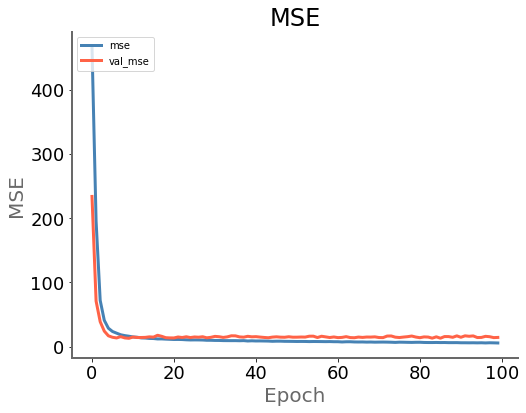

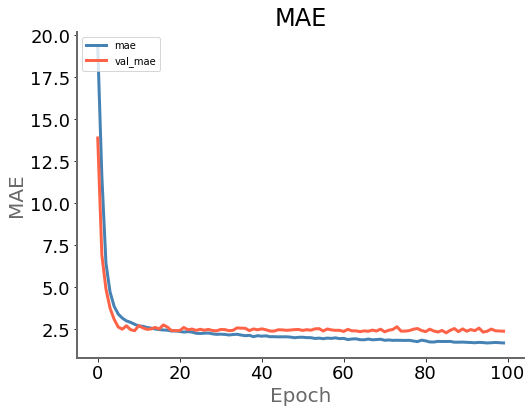

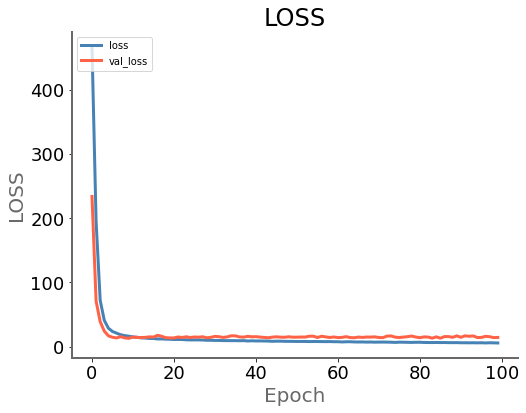

In [12]:
pwk.plot_history(history, plot={'MSE' :['mse', 'val_mse'],
                                'MAE' :['mae', 'val_mae'],
                                'LOSS':['loss','val_loss']}, save_as='01-history')

## Step 7 - Restore a model :

### 7.1 - Reload model

In [13]:
loaded_model = tf.keras.models.load_model('./run/models/best_model.h5')
loaded_model.summary()
print("Loaded.")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_n1 (Dense)             (None, 64)                896       
_________________________________________________________________
Dense_n2 (Dense)             (None, 64)                4160      
_________________________________________________________________
Output (Dense)               (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________
Loaded.


### 7.2 - Evaluate it :

In [14]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('x_test / loss      : {:5.4f}'.format(score[0]))
print('x_test / mae       : {:5.4f}'.format(score[1]))
print('x_test / mse       : {:5.4f}'.format(score[2]))

x_test / loss      : 12.8156
x_test / mae       : 2.4046
x_test / mse       : 12.8156


### 7.3 - Make a prediction

In [15]:
my_data = [ 1.26425925, -0.48522739,  1.0436489 , -0.23112788,  1.37120745,
       -2.14308942,  1.13489104, -1.06802005,  1.71189006,  1.57042287,
        0.77859951,  0.14769795,  2.7585581 ]
real_price = 10.4

my_data=np.array(my_data).reshape(1,13)

In [16]:
predictions = loaded_model.predict( my_data )
print("Prediction : {:.2f} K$   Reality : {:.2f} K$".format(predictions[0][0], real_price))

Prediction : 9.21 K$   Reality : 10.40 K$


In [17]:
pwk.end()

End time is : Tuesday 26 January 2021, 19:55:00
Duration is : 00:00:10 565ms
This notebook ends here


---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>